# Crossview - Simplified

## Introduction

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt


class Encoder(nn.Module):
    def __init__(self, image_channels, hidden_dims, output_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, hidden_dims, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dims, hidden_dims * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dims * 2 * (image_size // 4) * (image_size // 4), output_dims),
            nn.ReLU()
        )
        
    def forward(self, x):
        phi = self.encoder(x)
        return phi


class Decoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, image_channels, image_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims * 2 * (image_size // 4) * (image_size // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dims * 2, image_size // 4, image_size // 4)),
            nn.ConvTranspose2d(hidden_dims * 2, hidden_dims, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dims, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()    # assuming input images are normalized to [0,1]
        )
        
    def forward(self, x):
        x = self.decoder(x)
        return x
    

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.PNG')]    # lists all PNG files in the directory

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert image to RGB
        
        if self.transform:
            image = self.transform(image)
        
        return image
    

def save_model(model, path):
    torch.save(model.state_dict(), path)



# ----- Setup ----- #

image_channels = 3      # for RGB images
image_size = 64         # assuming 64x64 images
hidden_dims = 64        # hidden dimensions
output_dims = 100       # size of phi
batch_size = 64
shuffle = True


encoder = Encoder(image_channels, hidden_dims, output_dims)
decoder = Decoder(output_dims, hidden_dims, image_channels, image_size)

# Loss function
criterion = nn.MSELoss()

# Optimizers
learning_rate = 1e-3
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to Torch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Define the Datasets
train_dataset = CustomDataset('dataset/labelled/train/aerial', transform=transform)
val_dataset = CustomDataset('dataset/labelled/val/aerial', transform=transform)

# Define the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)





# ----- Training ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
decoder.to(device)


num_epochs = 1

for epoch in range(num_epochs):

    total_loss = 0
    
    for images in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        
        # Forward pass through encoder and decoder
        phi = encoder(images)
        recon_images = decoder(phi)
        
        # Calculate loss
        loss = criterion(recon_images, images)
        
        # Backward pass and optimize
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_loss += loss.item()

    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader):.4f}')     # update tqdm with average loss



# After training, save the models
encoder_save_path = 'encoder_model.pth'
decoder_save_path = 'decoder_model.pth'
save_model(encoder, encoder_save_path)
save_model(decoder, decoder_save_path)

## Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
decoder.to(device)


num_epochs = 1

for epoch in range(num_epochs):

    total_loss = 0
    
    for images in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        
        # Forward pass through encoder and decoder
        phi = encoder(images)
        recon_images = decoder(phi)
        
        # Calculate loss
        loss = criterion(recon_images, images)
        
        # Backward pass and optimize
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_loss += loss.item()

    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader):.4f}')     # update tqdm with average loss



# After training, save the models
encoder_save_path = 'encoder_model.pth'
decoder_save_path = 'decoder_model.pth'
save_model(encoder, encoder_save_path)
save_model(decoder, decoder_save_path)

Epoch 1/1: 100%|██████████| 135/135 [10:18<00:00,  4.58s/it]

Epoch [1/1], Loss: 0.2058


## Validation

## Inference

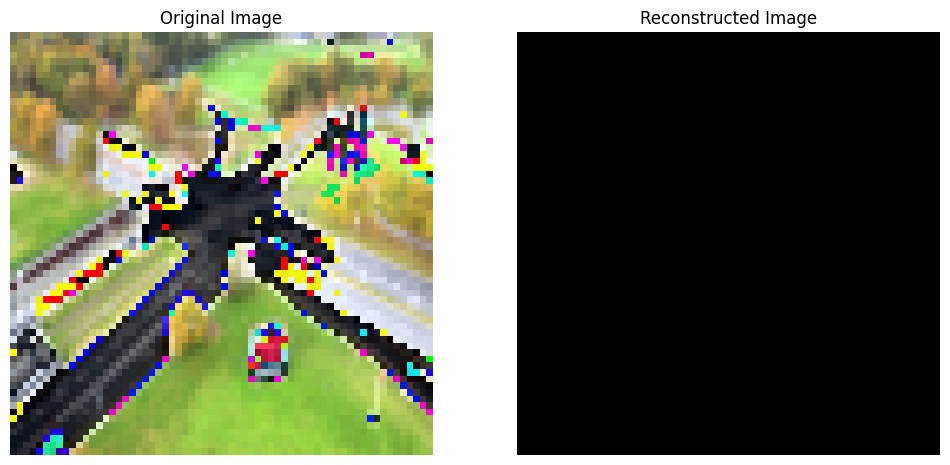

In [8]:
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt


# Initialize the models
encoder = Encoder(image_channels, hidden_dims, output_dims).to(device)
decoder = Decoder(output_dims, hidden_dims, image_channels, image_size).to(device)

# Load the saved model weights
encoder.load_state_dict(torch.load('encoder_model.pth', map_location=device))
decoder.load_state_dict(torch.load('decoder_model.pth', map_location=device))

# Set the models to evaluation mode
encoder.eval()
decoder.eval()


def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transforms.Resize((64, 64))(image)  # Resize to the same size as during training
    image = to_tensor(image)  # Convert to tensor
    image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)  # Normalize
    return image.unsqueeze(0).to(device)  # Add batch dimension and send to device


def infer_and_plot(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Perform inference
    with torch.no_grad():
        phi = encoder(image)
        recon_image = decoder(phi)
    
    # Convert images to PIL for visualization
    image = to_pil_image(image.squeeze().cpu())
    recon_image = to_pil_image(recon_image.squeeze().cpu())
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(recon_image)
    ax[1].set_title('Reconstructed Image')
    ax[1].axis('off')
    
    plt.show()

# Example usage
image_path = 'dataset/labelled/val/aerial/scene_1_Cortex_Park_crossroads_drone_000017.PNG'
infer_and_plot(image_path)
